# **Import Modules**

Mengimpor pustaka atau modul yang diperlukan untuk manipulasi data, visualisasi, pemrosesan model machine learning, dan pelatihan model neural network. Fokus utama dari kode ini adalah menyiapkan lingkungan dan dependensi yang dibutuhkan untuk membaca data, melakukan praproses, membangun arsitektur model berbasis embedding dan dense layer, serta menyiapkan mekanisme pelatihan yang stabil dengan bantuan callback untuk menghindari overfitting

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import warnings
import tensorflow as tf
import time
import random
import math

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import (
    Input, Embedding, Flatten, Dropout, Dense, Concatenate,
    BatchNormalization, Multiply
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

warnings.filterwarnings('ignore')

# **Download Dataset**

Proses mengunduh dataset `Goodbooks-10k` dari Kaggle secara langsung ke lingkungan kerja menggunakan kagglehub, lalu mencetak path atau lokasi direktori tempat dataset tersebut disimpan. Langkah ini penting untuk memastikan bahwa file dataset telah tersedia secara di colab.

In [2]:
path = kagglehub.dataset_download("zygmunt/goodbooks-10k")

print("Path to dataset files:", path)

100%|██████████| 11.6M/11.6M [00:00<00:00, 81.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zygmunt/goodbooks-10k/versions/5


# **Load Dataset**

Me-load dua file utama dari dataset, yaitu `books.csv` dan `ratings.csv`, ke dalam bentuk DataFrame. Setelah itu, data rating diurutkan kolomnya agar sesuai dengan kebutuhan dan lebih rapi.

In [3]:
books = pd.read_csv(path + "/books.csv")
ratings = pd.read_csv(path + "/ratings.csv")

# **Data Understanding**

Pada tahap awal *Data Understanding*, dilakukan dua fungsi dasar mengenai data yang akan digunakan. Dua fungsi tersebut adalah `info()` dan `describe()`.

* Fungsi `info()` digunakan untuk melihat struktur data secara umum, seperti jumlah baris, nama kolom, tipe data setiap kolom, serta jumlah nilai yang tidak null.
* Sedangkan fungsi `describe()` digunakan untuk melihat statistik deskriptif dari kolom-kolom numerik, seperti nilai minimum, maksimum, rata-rata, standar deviasi, serta kuartil.


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


In [5]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [6]:
ratings.describe()

,book_id,user_id,rating
count,981756.000000,981756.000000,981756.000000
mean,4943.275636,25616.759933,3.856534
std,2873.207415,15228.338826,0.983941
min,1.000000,1.000000,1.000000
25%,2457.000000,12372.000000,3.000000
50%,4921.000000,25077.000000,4.000000
75%,7414.000000,38572.000000,5.000000
max,10000.000000,53424.000000,5.000000


In [7]:
books.describe()

,id,book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


## Distribusi Rating

Memvisualisasikan distribusi nilai rating yang diberikan oleh pengguna terhadap buku. Dengan menggunakan diagram batang, grafik ini menunjukkan seberapa sering setiap nilai rating (1 - 5) diberikan dalam dataset.

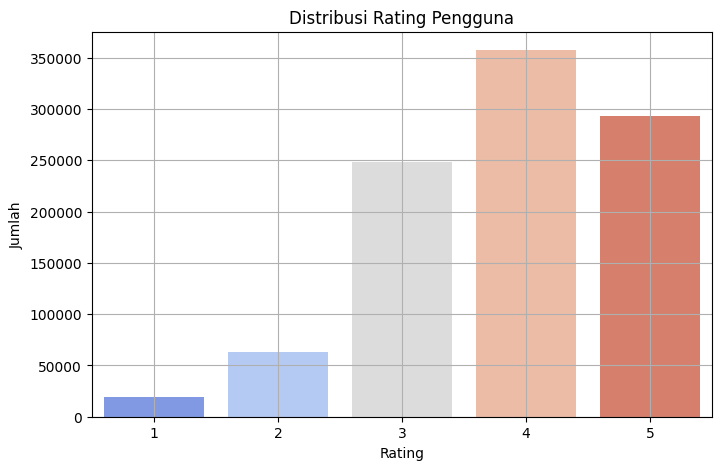

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(data=ratings, x='rating', palette='coolwarm')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.grid(True)
plt.show()

Berdasarkan grafik distribusi rating pengguna, terlihat bahwa mayoritas pengguna cenderung memberikan rating tinggi, dengan rating 4 menjadi yang paling banyak diberikan, disusul oleh rating 5. Sebaliknya, rating rendah seperti 1 dan 2 jarang diberikan, menunjukkan bahwa pengguna cenderung memiliki persepsi positif terhadap film yang mereka tonton. Rating 3 sebagai nilai tengah juga cukup banyak muncul, mencerminkan adanya penilaian netral. Distribusi ini bersifat positif atau condong ke arah rating tinggi, yang merupakan pola umum dalam data rating film. Pola ini penting untuk diperhatikan saat membangun sistem rekomendasi, karena kecenderungan pengguna memberikan rating tinggi dapat memengaruhi cara model dalam membedakan preferensi antar pengguna.


## Rating per-User

Memvisualisasikan sebaran jumlah buku yang dirating oleh setiap pengguna. Dengan menghitung jumlah rating per `user_id`, kemudian menampilkannya dalam bentuk histogram, grafik ini membantu mengidentifikasi apakah sebagian besar pengguna hanya memberikan sedikit rating atau ada pengguna yang sangat aktif.


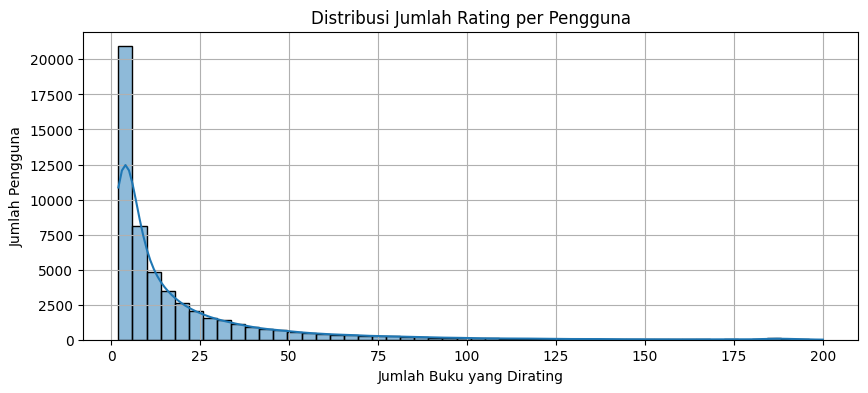

In [9]:
user_rating_count = ratings.groupby('user_id')['book_id'].count()

plt.figure(figsize=(10, 4))
sns.histplot(user_rating_count, bins=50, kde=True)
plt.title('Distribusi Jumlah Rating per Pengguna')
plt.xlabel('Jumlah Buku yang Dirating')
plt.ylabel('Jumlah Pengguna')
plt.grid(True)
plt.show()

Dari histogram “Distribusi Jumlah Rating per Pengguna” di atas, dapat dilihat bahwa mayoritas pengguna hanya memberi rating pada sejumlah kecil buku (misalnya 1–5 buku), di mana puncak tertinggi (sekitar 20.000 pengguna) berada pada bin paling kiri (pengguna yang memberi rating sangat rendah). Seiring meningkatnya jumlah buku yang dirating per pengguna, jumlah pengguna menurun drastis—misalnya hanya beberapa ribu pengguna yang merating sekitar 10–20 buku, dan semakin sedikit lagi (beberapa ratus atau puluhan saja) yang merating puluhan hingga ratusan buku. Kurva kepadatan mempertegas pola ini: sangat “menonjol” di nilai rendah dan kemudian memerah ke kanan dengan ekor panjang hingga sekitar 200 buku. Artinya, distribusi ini sangat miring ke kanan (right-skewed): sebagian besar pengguna bersifat “casual” dengan sedikit interaksi (sedikit memberi rating), sedangkan hanya segelintir “power user” yang banyak merating buku.


## Rating Per-Book

Memvisualisasikan distribusi jumlah rating yang diterima oleh setiap buku. Dengan menghitung berapa banyak pengguna yang memberi rating pada masing-masing `book_id`, kemudian menampilkannya dalam histogram, grafik ini membantu menunjukkan apakah sebagian besar buku hanya memiliki sedikit rating atau ada buku tertentu yang sangat populer.

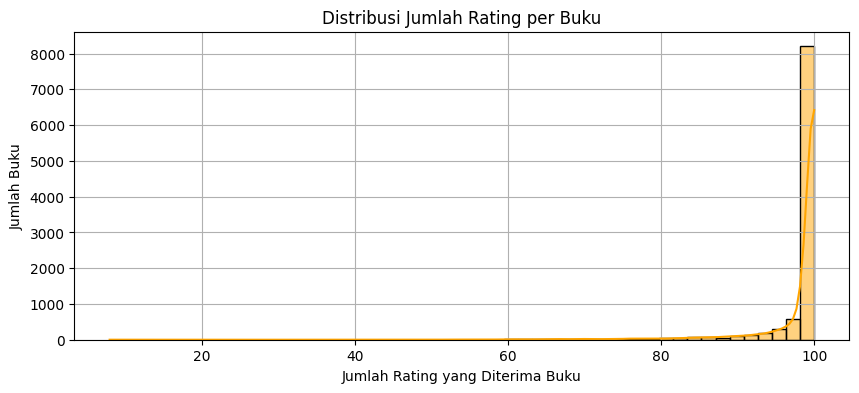

In [10]:
book_rating_count = ratings.groupby('book_id')['user_id'].count()

plt.figure(figsize=(10, 4))
sns.histplot(book_rating_count, bins=50, kde=True, color='orange')
plt.title('Distribusi Jumlah Rating per Buku')
plt.xlabel('Jumlah Rating yang Diterima Buku')
plt.ylabel('Jumlah Buku')
plt.grid(True)
plt.show()

Dari histogram tersebut terlihat bahwa hampir seluruh buku dalam dataset mengumpulkan jumlah rating yang sangat tinggi—terkonsentrasi di kisaran 90–100—sementara sangat sedikit buku yang mendapat rating di bawah 50, sehingga distribusinya tampak sangat miring ke kanan; hal ini menandakan bahwa data kemungkinan hanya mencakup buku-buku populer yang sudah memiliki basis pembaca/rater besar, sehingga nilai rata‐rata jumlah rating per buku menjadi sangat dekat dengan batas atas (100).

## Hitung Missing Value

Memeriksa apakah ada nilai yang hilang (missing values) dalam dataset `books.csv` dan `ratings.csv`. Dengan menghitung jumlah nilai kosong pada setiap kolom, kemudian menampilkan hanya kolom-kolom yang memiliki data hilang

In [11]:
missing_books = books.isnull().sum()
missing_books = missing_books[missing_books > 0]
print("Missing values di books.csv:")
print(missing_books)

Missing values di books.csv:
isbn                          700
isbn13                        585
original_publication_year      21
original_title                585
language_code                1084
dtype: int64


Masih terdapat beberapa detail tentang buku yang tidak lengkap. Namun hal ini tidak akan menjadi masalah karena fokus kita adalah melakukan Collaborative Filtering User-Based dengan fokus pada data rating saja.

In [12]:
missing_rating = ratings.isnull().sum()
missing_rating = missing_rating[missing_rating > 0]
print("Missing values di rating.csv:")
print(missing_rating)

Missing values di rating.csv:
Series([], dtype: int64)


Seluruh buku telah dirating oleh pengguna

# **Data Preparation**

## Pemisahan Fitur dan Target

Pemisahan data fitur dan target untuk model rekomendasi, di mana X berisi pasangan pengguna dan buku, dan y berisi nilai rating.

In [13]:
user_enc = LabelEncoder()
ratings['user_id_encoded'] = user_enc.fit_transform(ratings['user_id'].values)

book_enc = LabelEncoder()
ratings['book_id_encoded'] = book_enc.fit_transform(ratings['book_id'].values)

In [14]:
X = ratings[['user_id_encoded', 'book_id_encoded']].values
y = ratings['rating'].values

## Train-Test Split

Distribusi rating tidak seimbang sehingga pembagian data train dan validasi dilakukan menggunakan `StratifiedShuffleSplit` agar proporsi rating pada kedua set tetap terjaga dengan rasio 80:20.


In [15]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in splitter.split(X, ratings['rating']):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

# **Modeling**

# **NeuMF (Neural Matrix Factorization)**

Pada project ini, salah satu model yang digunakan adalah **NeuMF** (Neural Matrix Factorization), sebuah model rekomendasi yang menggabungkan pendekatan **Generalized Matrix Factorization** (GMF) dan **Multi-Layer Perceptron** (MLP) untuk memodelkan interaksi non-linear antara pengguna dan item. Biasanya, NeuMF dirancang untuk menangani persoalan personalized ranking berbasis implicit feedback seperti klik atau pembelian. Namun, dalam eksperimen ini saya memodifikasi model tersebut untuk menangani masalah explicit feedback, yaitu prediksi rating numerik secara langsung. Perubahan utama terletak pada layer output yang diubah menjadi layer regresi linear dengan fungsi aktivasi linear, sehingga model dapat memprediksi skor rating kontinu. Selain itu, saya menggunakan loss function MSE (Mean Squared Error) dan metrik seperti MAE dan RMSE yang lebih sesuai untuk evaluasi prediksi nilai rating.

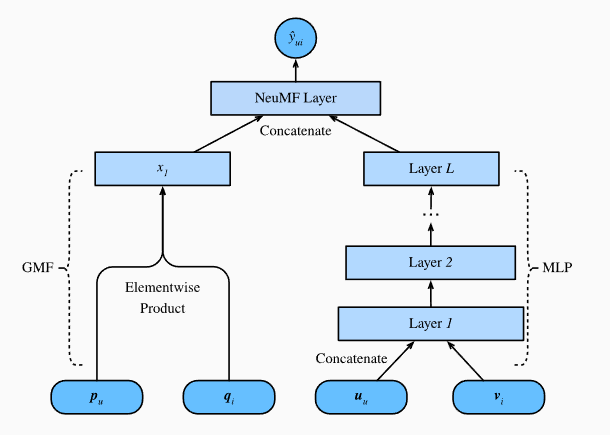

## Parameter Dasar

- `embedding_dim (32)`: Ukuran vektor embedding untuk merepresentasikan pengguna dan item. Semakin besar nilai ini, model bisa menangkap pola lebih kompleks, tapi berisiko overfitting dan butuh komputasi lebih.

- `l2_reg_emb (1e-4)`: Besaran regularisasi L2 pada embedding untuk mencegah bobot menjadi terlalu besar. Membantu mengurangi overfitting dengan menjaga bobot tetap kecil dan stabil.

- `dropout_rate (0.5)`: Proporsi neuron yang secara acak dimatikan saat pelatihan untuk mencegah overfitting. Nilai 0.5 berarti 50% neuron dropout, sehingga model lebih tahan terhadap ketergantungan berlebihan pada fitur tertentu.

In [16]:
embedding_dim = 32
l2_reg_emb = 1e-4
dropout_rate = 0.2

## Input Layer

* Layer ini berfungsi sebagai titik masuk data ke jaringan saraf.
* **Parameter `shape=(1,)`** berarti input yang diterima berupa tensor berdimensi 1 dengan panjang 1, yaitu satu nilai integer yang mewakili ID pengguna atau ID buku.
* **Parameter `name`** memberi nama pada layer untuk memudahkan identifikasi saat debugging atau visualisasi model.



In [17]:
# Input Layer
user_input = Input(shape=(1,), name='user_input')
book_input = Input(shape=(1,), name='book_input')

## GMF Branch
Tujuan dari menghitung `n_users = ratings['user_id'].nunique()` dan `n_books = ratings['book_id'].nunique()` adalah untuk **menentukan ukuran input** dari layer embedding `Embedding()` dalam model, khususnya untuk GMF (Generalized Matrix Factorization) pada model NeuMF. Ringkasnya`n_users` dan `n_books` digunakan untuk memastikan layer embedding memiliki kapasitas untuk menangani seluruh ID unik dari user dan book dalam data. Tanpa ini, model tidak akan tahu berapa banyak representasi yang harus dipelajari.


**1. Embedding Layer (`user_emb_gmf` dan `book_emb_gmf`)**

* **Fungsi:** Mengubah input ID pengguna (`user_input`) dan ID buku (`book_input`), yang berupa angka diskrit, menjadi representasi vektor berdimensi tetap (`embedding_dim = 32`).
* **Parameter penting:**

  * `input_dim` menentukan jumlah total kategori (jumlah pengguna `n_users` atau buku `n_books`), sehingga embedding dapat memetakan setiap ID unik ke vektor.
  * `output_dim` menentukan ukuran vektor embedding, yang mengontrol kompleksitas representasi.
  * `embeddings_regularizer=l2(l2_reg_emb)` menambahkan regularisasi L2 untuk mencegah bobot embedding menjadi terlalu besar dan overfitting.

**2. Flatten Layer (`user_vec_gmf`, `book_vec_gmf`)**

* **Fungsi:** Mengubah output embedding yang berbentuk tensor 2D `(batch_size, 1, embedding_dim)` menjadi tensor 1D `(batch_size, embedding_dim)` agar bisa diproses oleh layer selanjutnya.

**3. Multiply Layer (`gmf_vector`)**

* **Fungsi:** Melakukan perkalian elemen-per-elemen (element-wise multiplication) antara vektor embedding pengguna dan buku.
* **Tujuan:** Memodelkan interaksi linier antara fitur pengguna dan item, mirip dengan dot product di matrix factorization klasik, tetapi dengan kemampuan untuk digabungkan dengan jaringan lain (MLP).


In [18]:
n_users = ratings['user_id'].nunique()
n_books = ratings['book_id'].nunique()

# Embedding Layer
user_emb_gmf = Embedding(
    input_dim=n_users,
    output_dim=embedding_dim,
    embeddings_regularizer=l2(l2_reg_emb),
    name='user_emb_gmf'
)(user_input)
book_emb_gmf = Embedding(
    input_dim=n_books,
    output_dim=embedding_dim,
    embeddings_regularizer=l2(l2_reg_emb),
    name='book_emb_gmf'
)(book_input)

# Flatten Layer
user_vec_gmf = Flatten()(user_emb_gmf)
book_vec_gmf = Flatten()(book_emb_gmf)

# Multiply Layer
gmf_vector = Multiply()([user_vec_gmf, book_vec_gmf])

## MLP Branch

**1. Embedding Layer (`user_emb_mlp` dan `book_emb_mlp`)**

* Sama seperti di GMF, layer ini mengubah ID pengguna dan buku menjadi vektor embedding berdimensi 32, dengan regularisasi L2 untuk mencegah overfitting.
* Tujuannya adalah menyediakan representasi fitur yang bisa dipelajari dan diolah lebih lanjut oleh jaringan MLP.

**2. Flatten Layer (`user_vec_mlp` dan `book_vec_mlp`)**

* Mengubah tensor embedding berdimensi `(batch_size, 1, embedding_dim)` menjadi vektor 1D `(batch_size, embedding_dim)` agar bisa diproses oleh lapisan Dense.

**3. Concatenate Layer (`mlp_input`)**

* Menggabungkan vektor embedding pengguna dan buku menjadi satu vektor berdimensi dua kali embedding\_dim (64).
* Ini memberikan informasi lengkap tentang pengguna dan item secara bersamaan untuk diproses oleh MLP.

**4. Dense Layer Stack (MLP)**

* **Dense Layer 1:** 64 neuron dengan aktivasi ReLU, dilengkapi regularisasi L2 kecil (`1e-5`), batch normalization, dan dropout 50% untuk stabilitas dan mencegah overfitting.
* **Dense Layer 2:** 32 neuron dengan aktivasi ReLU dan regularisasi serta dropout yang sama seperti sebelumnya.
* **Batch Normalization:** Membantu mempercepat pelatihan dan menstabilkan distribusi aktivasi.
* **Dropout:** Mengurangi risiko overfitting dengan secara acak menonaktifkan 50% neuron selama pelatihan.



In [19]:
# Embedding Layer
user_emb_mlp = Embedding(
    input_dim=n_users,
    output_dim=embedding_dim,
    embeddings_regularizer=l2(l2_reg_emb),
    name='user_emb_mlp'
)(user_input)

book_emb_mlp = Embedding(
    input_dim=n_books,
    output_dim=embedding_dim,
    embeddings_regularizer=l2(l2_reg_emb),
    name='book_emb_mlp'
)(book_input)

# Flatten Layer
user_vec_mlp = Flatten()(user_emb_mlp)
book_vec_mlp = Flatten()(book_emb_mlp)

# Concatenate Layer
mlp_input = Concatenate(name='mlp_concat')([user_vec_mlp, book_vec_mlp])

# Dense Layer Stack (MLP)
mlp = Dense(64, activation='relu',
            kernel_regularizer=l2(1e-5),
            name='mlp_dense_1')(mlp_input)
mlp = BatchNormalization()(mlp)
mlp = Dropout(dropout_rate)(mlp)

mlp = Dense(32, activation='relu',
    kernel_regularizer=l2(1e-5),
    name='mlp_dense_3')(mlp)
mlp = BatchNormalization()(mlp)
mlp = Dropout(dropout_rate)(mlp)

## Concat MLP Branch & GMF Branch

* **Concatenate Layer** yang menggabungkan output dari dua cabang:

  * `gmf_vector` (hasil dari GMF branch — interaksi linier)
  * `mlp` (hasil dari MLP branch — interaksi non-linear)

* **Fungsi:** Menggabungkan dua jenis representasi interaksi (linier dan non-linier) dalam satu vektor sebagai masukan untuk prediksi akhir.

* **Hasil:** Vektor gabungan yang lebih kaya informasi dan mampu menangkap pola interaksi pengguna-item yang sederhana maupun kompleks.

In [20]:
# 5. Gabungkan GMF & MLP
neumf_concat = Concatenate(name='neumf_concat')([gmf_vector, mlp])

## Output Layer (Regresi Rating)

**1. Dense Layer (`prediction`)**

* Layer ini menghasilkan output akhir berupa **prediksi rating eksplisit** (nilai kontinu, seperti 1–5).
* **Units = 1**: Hanya satu neuron output karena hanya memprediksi satu nilai rating per pasangan user–item.
* **Activation = 'linear'**: Fungsi aktivasi linear digunakan agar output tidak dibatasi, sesuai untuk tugas regresi.
* **Kernel Initializer = 'lecun\_uniform'**: Strategi inisialisasi bobot yang cocok untuk aktivasi linear, memastikan stabilitas saat pelatihan.
* **Kernel Regularizer = L2 (`1e-5`)**: Regularisasi L2 membantu mencegah overfitting dengan menghukum bobot yang terlalu besar.

**2. Model API (`model`)**

* `Model(inputs=[user_input, book_input], outputs=prediction)` membuat objek model dengan dua input (ID pengguna dan ID buku) dan satu output (rating).
* Ini menyatukan keseluruhan arsitektur: input → GMF & MLP → gabungan → output regresi.

In [21]:
# 6. Output layer (regresi rating) dengan L2 pada kernel
prediction = Dense(
    1,
    activation='linear',
    kernel_initializer='lecun_uniform',
    kernel_regularizer=l2(1e-5),
    name='prediction'
)(neumf_concat)

model_neu = Model(inputs=[user_input, book_input], outputs=prediction)

## Compile Model

**1. Optimizer (`Adam`)**

* Menggunakan **Adam** (Adaptive Moment Estimation), yaitu optimizer yang secara otomatis menyesuaikan learning rate selama pelatihan.
* **Learning Rate = 1e-4**: Nilai yang relatif kecil untuk memastikan proses pembelajaran berjalan stabil dan perlahan menghindari local minima.


**2. Compile**

### Loss Function:

* **MSE (Mean Squared Error)** digunakan karena ini adalah tugas regresi.

  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $$


### Metrics:

* **MAE (Mean Absolute Error)**
  Mengukur rata-rata selisih absolut antara nilai aktual dan prediksi.
  Rumus:

  $$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
  $$

* **RMSE (Root Mean Squared Error)**
  Akar dari MSE, memberi penalti lebih besar pada error yang besar.
  Rumus:

  $$
  \text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
  $$


**3. Model Summary**

* Menampilkan struktur model lengkap: nama layer, output shape, jumlah parameter, dan total parameter yang bisa dilatih.

In [22]:
# 7. Compile dengan learning rate lebih rendah
optimizer = Adam(learning_rate=1e-4)
model_neu.compile(optimizer=optimizer, loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
model_neu.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb_mlp        │ (None, 1, 32)     │  1,709,568 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_emb_mlp        │ (None, 1, 32)     │    320,000 │ book_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ user_emb_mlp[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 32)        │          0 │ book_emb_mlp[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_concat          │ (None, 64)        │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_dense_1 (Dense) │ (None, 64)        │      4,160 │ mlp_concat[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ mlp_dense_1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb_gmf        │ (None, 1, 32)     │  1,709,568 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_emb_gmf        │ (None, 1, 32)     │    320,000 │ book_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_dense_3 (Dense) │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ user_emb_gmf[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ book_emb_gmf[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ mlp_dense_3[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32)        │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neumf_concat        │ (None, 64)        │          0 │ multiply[0][0],   │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,065,825 (15.51 MB)

 Trainable params: 4,065,633 (15.51 MB)

 Non-trainable params: 192 (768.00 B)

## Training Model

**1. EarlyStopping Callback**

EarlyStopping digunakan untuk menghentikan proses pelatihan lebih awal jika model tidak menunjukkan peningkatan pada data validasi.

* `monitor='val_loss'`: Memantau nilai loss pada data validasi.
* `patience=10`: Jika tidak ada peningkatan dalam 10 epoch berturut-turut, pelatihan dihentikan.
* `restore_best_weights=True`: Setelah pelatihan dihentikan, bobot model akan dikembalikan ke nilai terbaik.
* `verbose=1`: Menampilkan pesan saat pelatihan dihentikan lebih awal.

**2. Model Training dengan `.fit()`**

Model dilatih menggunakan data pelatihan dan dievaluasi pada data validasi di setiap epoch.

* Input terdiri dari dua fitur: ID pengguna dan ID buku.
* Target yang diprediksi adalah rating eksplisit (`y_train`).
* `validation_data`: Menyediakan data validasi untuk pemantauan performa model.
* `epochs=50`: Maksimal jumlah epoch, namun bisa berhenti lebih cepat jika EarlyStopping aktif.
* `batch_size=1024`: Jumlah sampel yang digunakan dalam satu kali update parameter.
* `callbacks=[early_stop]`: Mengaktifkan fungsi EarlyStopping.
* `verbose=1`: Menampilkan progress pelatihan secara ringkas per epoch.

In [23]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history_neu = model_neu.fit(
    [X_train[:, 0], X_train[:, 1]], y_train,
    validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
    epochs=50,
    batch_size=512,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 14.6969 - mae: 3.6359 - root_mean_squared_error: 3.8091 - val_loss: 6.7161 - val_mae: 2.3839 - val_root_mean_squared_error: 2.5738 - learning_rate: 1.0000e-04
Epoch 2/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.9119 - mae: 1.8876 - root_mean_squared_error: 2.1835 - val_loss: 1.1922 - val_mae: 0.8723 - val_root_mean_squared_error: 1.0488 - learning_rate: 1.0000e-04
Epoch 3/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.7061 - mae: 1.0146 - root_mean_squared_error: 1.2702 - val_loss: 0.9884 - val_mae: 0.7698 - val_root_mean_squared_error: 0.9468 - learning_rate: 1.0000e-04
Epoch 4/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.3954 - mae: 0.9096 - root_mean_squared_error: 1.1417 - val_loss: 0.9361 - val_mae: 0.7420 - val_root_mean_squared_error: 0.9192 - learning_rate: 1.0000e-04
Epoch 5/50
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.1969 - mae: 0.8384 - root_mean_squared_error: 1.0516 -

## Rekomendasi Top-N

Fungsi ini menghasilkan rekomendasi **Top-N buku** untuk seorang user berdasarkan model prediksi (misalnya NeuMF). Langkah-langkahnya:

1. **Encode `user_id`** → indeks integer.
2. **Ambil daftar buku yang sudah dirating user.**
3. **Cari buku-buku yang belum dirating.**
4. **Prediksi rating** user terhadap semua buku yang belum dirating.
5. **Ambil N buku dengan prediksi tertinggi.**
6. **Mapping kembali ke `book_id`, ambil info judul & penulis dari DataFrame `books`.**
7. **Kembalikan hasil dalam bentuk DataFrame dan tampilkan ke layar.**

In [33]:
def get_top_n_recommendations_encoded(model, ratings, books, user_id, N=10):

    # 2. Mulai catat waktu eksekusi
    start_time = time.time()

    # Transform user_id asli ke format encoded (0 sampai N-1)
    try:
        user_id_enc = user_enc.transform([user_id])[0]
    except ValueError:
        print(f"User {user_id} tidak ditemukan dalam data training.")
        return pd.DataFrame()

    # Ambil daftar buku yang sudah dirating user (pakai ID Asli untuk filter dari DataFrame)
    rated_books_by_user = ratings.loc[ratings['user_id'] == user_id, 'book_id'].tolist()

    # Cari buku-buku yang belum dirating (ID Asli)
    all_books = ratings['book_id'].unique()
    unrated_books = np.setdiff1d(all_books, rated_books_by_user)

    if len(unrated_books) == 0:
        print(f"User {user_id} sudah merating semua buku.")
        return pd.DataFrame()

    # Transform unrated_books (buku yang belum dibaca) ke format encoded
    unrated_books_enc = book_enc.transform(unrated_books)

    # Siapkan array input menggunakan ID ENCODED
    user_array = np.full(shape=(len(unrated_books_enc),), fill_value=user_id_enc, dtype=np.int32)
    book_array = unrated_books_enc

    # Prediksi menggunakan ID Encoded
    preds = model.predict([user_array, book_array], batch_size=4096, verbose=0).flatten()

    # Ambil N buku dengan prediksi tertinggi
    top_n_indices = np.argsort(preds)[::-1][:N]

    # KEMBALIKAN KE ID BUKU ASLI untuk pencarian info judul dan penulis
    top_books_asli = unrated_books[top_n_indices]
    top_scores = preds[top_n_indices]

    # Susun hasil
    results = []
    for book_id, score in zip(top_books_asli, top_scores):
        match = books[books['id'] == book_id] # Pencarian info pakai ID Asli

        if not match.empty:
            title = match['title'].values[0]
            author = match['authors'].values[0]
        else:
            title = "(Unknown Title)"
            author = "(Unknown Author)"

        results.append({
            'book_id': book_id,
            'pred_rating': min(score, 5.0), # Membatasi tampilan rating maksimal 5.0
            'title': title,
            'authors': author
        })

    top_n_df = pd.DataFrame(results)

    # 3. Hentikan timer dan hitung durasinya
    end_time = time.time()
    inference_time = end_time - start_time

    # 4. Tampilkan durasi di output layar
    print(f"\nTop {N} recommendations for user {user_id} (Generated in {inference_time:.4f} seconds):\n")
    for idx, row in top_n_df.iterrows():
        print(f"Book ID: {row['book_id']}, Predicted Rating: {row['pred_rating']:.4f}")
        print(f"Title:  {row['title']}")
        print(f"Author: {row['authors']}")
        print("-" * 30)

    return top_n_df

_ = get_top_n_recommendations_encoded(model_neu, ratings, books, user_id=4, N=100)


Top 100 recommendations for user 4 (Generated in 0.1221 seconds):

Book ID: 6920, Predicted Rating: 5.0000
Title:  The Indispensable Calvin and Hobbes
Author: Bill Watterson
------------------------------
Book ID: 6862, Predicted Rating: 4.8695
Title:  March: Book One (March, #1)
Author: John             Lewis, Andrew Aydin, Nate Powell
------------------------------
Book ID: 8548, Predicted Rating: 4.8615
Title:  This is Not My Hat
Author: Jon Klassen
------------------------------
Book ID: 1788, Predicted Rating: 4.8600
Title:  The Calvin and Hobbes Tenth Anniversary Book
Author: Bill Watterson
------------------------------
Book ID: 3628, Predicted Rating: 4.8428
Title:  The Complete Calvin and Hobbes
Author: Bill Watterson
------------------------------
Book ID: 2244, Predicted Rating: 4.8405
Title:  Saga, Vol. 2 (Saga, #2)
Author: Brian K. Vaughan, Fiona Staples
------------------------------
Book ID: 4522, Predicted Rating: 4.8237
Title:  Saga, Vol. 5 (Saga, #5)
Author: Brian K.

# **Evaluasi**

In [31]:
def evaluate_ranking_sampled(model, ratings, X_train, X_val, y_val, K=10, num_users=100, num_negatives=99):
    print(f"Memulai evaluasi ranking (Target vs {num_negatives} Negatives) untuk Top-{K}...\n")

    # 1. Definisikan Ground Truth dari data validasi (Rating >= 4.0)
    val_df = pd.DataFrame({'user_id_encoded': X_val[:, 0], 'book_id_encoded': X_val[:, 1], 'rating': y_val})
    relevant_df = val_df[val_df['rating'] >= 4.0]

    unique_users = relevant_df['user_id_encoded'].unique()

    np.random.seed(42)
    random.seed(42)
    sample_users = np.random.choice(unique_users, min(num_users, len(unique_users)), replace=False)

    hits = []
    ndcgs = []

    # Kumpulan semua buku untuk sampling
    all_books = set(ratings['book_id_encoded'].unique())

    for user in sample_users:
        # Ground Truth: Buku yang terbukti disukai
        ground_truth = relevant_df[relevant_df['user_id_encoded'] == user]['book_id_encoded'].tolist()

        if not ground_truth:
            continue

        # Semua buku yang pernah berinteraksi dengan user (Train + Val)
        user_interacted = set(ratings[ratings['user_id_encoded'] == user]['book_id_encoded'].unique())

        # Buku yang tidak pernah disentuh user sama sekali
        negative_candidates = list(all_books - user_interacted)

        # Ambil sampel negatif (misal: 99 buku acak)
        if len(negative_candidates) < num_negatives:
            sampled_negatives = negative_candidates
        else:
            sampled_negatives = random.sample(negative_candidates, num_negatives)

        # Gabungkan Ground Truth dan Sampel Negatif menjadi daftar Kandidat
        candidates = np.array(list(set(ground_truth) | set(sampled_negatives)))

        # Prediksi skor hanya untuk kandidat tersebut
        user_array = np.full(len(candidates), user, dtype=np.int32)
        preds = model.predict([user_array, candidates], batch_size=4096, verbose=0).flatten()

        # Ambil Top K
        top_k_indices = np.argsort(preds)[::-1][:K]
        top_k_books = candidates[top_k_indices]

        # Hitung Hit Ratio @ K
        hit = 1 if any(book in ground_truth for book in top_k_books) else 0
        hits.append(hit)

        # Hitung NDCG @ K
        dcg = 0.0
        for i in range(K):
            if top_k_books[i] in ground_truth:
                dcg += 1.0 / math.log2(i + 2)

        idcg = 0.0
        num_relevant = min(len(ground_truth), K)
        for i in range(num_relevant):
            idcg += 1.0 / math.log2(i + 2)

        ndcg = dcg / idcg if idcg > 0 else 0
        ndcgs.append(ndcg)

    mean_hr = np.mean(hits)
    mean_ndcg = np.mean(ndcgs)

    print("-" * 30)
    print(f"Hasil Evaluasi pada {len(sample_users)} user sampel:")
    print(f"Hit Ratio@{K} (HR@{K}) : {mean_hr:.4f} ({(mean_hr*100):.2f}%)")
    print(f"NDCG@{K}              : {mean_ndcg:.4f}")
    print("-" * 30)

    return mean_hr, mean_ndcg

# Eksekusi evaluasi yang adil
hr_10, ndcg_10 = evaluate_ranking_sampled(model_neu, ratings, X_train, X_val, y_val, K=10, num_users=100)

Memulai evaluasi ranking (Target vs 99 Negatives) untuk Top-10...

------------------------------
Hasil Evaluasi pada 100 user sampel:
Hit Ratio@10 (HR@10) : 0.2400 (24.00%)
NDCG@10              : 0.0558
------------------------------


## Visualisasi Kurva Loss

Plot ini digunakan untuk memantau performa model selama proses pelatihan. Kurva menunjukkan bagaimana nilai **loss** pada data pelatihan (`Train Loss`) dan data validasi (`Validation Loss`) berubah seiring bertambahnya epoch.

* Sumbu **x** menunjukkan jumlah epoch (iterasi pelatihan).
* Sumbu **y** menunjukkan nilai loss (MSE) pada masing-masing epoch.
* Kurva **Train Loss** mencerminkan seberapa baik model mempelajari data pelatihan.
* Kurva **Validation Loss** menunjukkan generalisasi model terhadap data yang tidak dilatih.

Tujuan dari visualisasi ini adalah untuk mendeteksi tanda-tanda **overfitting** (misalnya, ketika `val_loss` meningkat sementara `loss` terus menurun) atau **underfitting** (kedua kurva tetap tinggi). Idealnya, kedua kurva menurun dan saling berdekatan.


In [ ]:
plt.figure(figsize=(12, 10))

plt.plot(history_neu.history['loss'], label='Train Loss')
plt.plot(history_neu.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Interpretasi

Pada awal pelatihan (epoch 0–1), nilai loss untuk data training dan validasi sangat tinggi (sekitar 15 dan 13) karena bobot model masih diinisialisasi secara acak. Namun, pada epoch pertama, terjadi penurunan drastis: loss training turun menjadi sekitar 7 dan loss validasi menjadi sekitar 3,5, menunjukkan bahwa model mulai mampu mengenali pola interaksi pengguna dan item. Pada epoch 1 hingga 5, loss terus menurun dengan cepat—training loss mencapai sekitar 2,5 dan validation loss mendekati 1,1—menandakan bahwa NeuMF berhasil menyesuaikan bobot embedding dan lapisan dense secara efektif. Setelah epoch ke-5, penurunan loss berjalan lebih lambat (epoch 5–15), dengan training loss turun dari ≈2,5 ke ≈1,1 dan validation loss dari ≈1,1 ke ≈0,8, menandakan model mulai mendekati konvergensi. Dari epoch 15 hingga 37, nilai loss keduanya konsisten berada pada kisaran 0,7–0,9 dengan selisih yang sangat kecil—bahkan terkadang validation loss lebih rendah—yang menunjukkan tidak terjadi overfitting dan model mampu melakukan generalisasi dengan baik. Karena kurva loss sudah melandai sejak sekitar epoch ke-25, pelatihan tambahan hanya memberikan peningkatan yang sangat minim.


## Visualisasi Kurva MAE

Kurva ini digunakan untuk memantau **Mean Absolute Error (MAE)** model selama proses pelatihan.

* Sumbu **x** menunjukkan jumlah epoch.
* Sumbu **y** menunjukkan nilai MAE, yaitu rata-rata selisih absolut antara prediksi model dan nilai rating sebenarnya.
* **Train MAE** menunjukkan performa model pada data pelatihan.
* **Validation MAE** menunjukkan seberapa baik model melakukan generalisasi pada data yang tidak dilatih.

MAE memberikan gambaran intuitif tentang rata-rata besar kesalahan model. Pola ideal adalah ketika kedua kurva menurun dan berada cukup dekat, yang menandakan model belajar dengan baik dan tidak overfitting.

In [ ]:
plt.figure(figsize=(12, 10))

plt.plot(history_neu.history['mae'], label='Train MAE')
plt.plot(history_neu.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Interpretasi

Pada awal pelatihan (epoch 0–1), nilai MAE (Mean Absolute Error) sangat tinggi, dengan MAE training sekitar 3,7 dan MAE validasi sekitar 3,5, yang mencerminkan prediksi awal model masih jauh dari nilai sebenarnya. Namun, penurunan tajam terjadi dalam beberapa epoch pertama: pada epoch ke-3, MAE training sudah turun ke kisaran 1,5 dan MAE validasi ke sekitar 1,0. Hal ini menunjukkan bahwa model NeuMF sangat cepat menangkap pola dasar dari interaksi pengguna dan item. Dari epoch 4 hingga 15, penurunan MAE masih terus berlangsung meski melambat; MAE training turun secara bertahap dari sekitar 1,3 menjadi 0,75, dan MAE validasi dari 0,95 menjadi sekitar 0,65. Selanjutnya, pada epoch 15–30, baik MAE training maupun validasi mendatar di kisaran 0,6–0,7, menandakan model mulai mencapai konvergensi. Menariknya, pada beberapa titik (sekitar epoch 30 ke atas), MAE validasi sedikit lebih tinggi daripada MAE training, namun selisihnya sangat kecil, sehingga tidak mengindikasikan overfitting signifikan. Secara keseluruhan, kurva MAE yang menurun konsisten dan mendatar menunjukkan bahwa model mampu belajar secara efektif dan menghasilkan prediksi rating yang cukup akurat serta stabil di data validasi.

## Visualisasi Kurva RMSE

Plot ini menunjukkan perubahan **Root Mean Squared Error (RMSE)** selama pelatihan model.

* Sumbu **x** menunjukkan jumlah epoch.
* Sumbu **y** menunjukkan nilai RMSE, yaitu akar dari rata-rata kuadrat selisih antara prediksi dan nilai sebenarnya.
* **Train RMSE** menggambarkan akurasi model terhadap data pelatihan.
* **Validation RMSE** menunjukkan performa model pada data validasi (yang tidak dilatih).

RMSE lebih sensitif terhadap error yang besar dibanding MAE, sehingga sangat berguna untuk mendeteksi prediksi yang jauh meleset.
Kurva yang ideal adalah saat kedua garis (train dan validation) turun dan relatif dekat, menandakan model belajar dengan baik dan tidak overfitting.

In [ ]:
plt.figure(figsize=(12, 10))

plt.plot(history_neu.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history_neu.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Model RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Interpretasi

Pada awal pelatihan (epoch 0–1), nilai RMSE (Root Mean Squared Error) sangat tinggi, dengan RMSE training mencapai hampir 3,9 dan RMSE validasi sekitar 3,7. Ini wajar karena model belum belajar dan bobot masih acak. Namun, terjadi penurunan drastis pada beberapa epoch pertama: pada epoch ke-3, RMSE training turun ke sekitar 2,0, sementara RMSE validasi sudah turun mendekati 1,2. Ini menunjukkan bahwa model NeuMF mampu dengan cepat menangkap pola interaksi pengguna–item. Dari epoch 4 hingga 15, penurunan RMSE berlanjut meskipun mulai melambat—RMSE training menurun dari sekitar 1,6 menjadi 0,9, dan RMSE validasi dari sekitar 1,0 menjadi 0,83. Mulai epoch 15 ke atas hingga akhir pelatihan (epoch 37), kurva RMSE cenderung datar, berada di kisaran 0,75–0,9. Pada epoch terakhir, RMSE training sedikit lebih rendah daripada RMSE validasi, tetapi perbedaannya sangat kecil dan stabil. Ini menandakan tidak ada overfitting yang signifikan, dan model berhasil mempertahankan kemampuan generalisasi yang baik. Penurunan RMSE yang konsisten dan stabil juga memperkuat bukti bahwa prediksi model semakin akurat dari waktu ke waktu, meskipun peningkatannya semakin kecil seiring bertambahnya epoch.



# **Kesimpulan**

Berdasarkan keseluruhan hasil plot untuk metrik Loss, MAE, dan RMSE selama 37 epoch pelatihan, dapat disimpulkan bahwa model NeuMF menunjukkan performa pelatihan yang sangat baik dan stabil. Ketiga metrik tersebut mengalami penurunan drastis pada beberapa epoch pertama, menandakan bahwa model dengan cepat mampu mempelajari pola interaksi antara pengguna dan item. Setelah itu, penurunan metrik berlangsung lebih lambat namun konsisten, hingga akhirnya mencapai fase konvergensi tanpa tanda-tanda overfitting—ditunjukkan oleh selisih yang kecil antara nilai training dan validation, bahkan pada epoch-epoch akhir. Hal ini membuktikan bahwa model tidak hanya mampu menyesuaikan diri dengan data pelatihan, tetapi juga mengeneralisasi dengan baik terhadap data yang belum pernah dilihat. Dengan MAE dan RMSE akhir yang rendah dan stabil, model dapat dianggap cukup akurat dalam memprediksi rating user terhadap item, serta siap untuk diimplementasikan lebih lanjut atau digunakan sebagai dasar sistem rekomendasi.